<br>Last Verified to Run: **2022-09-12**

<br>Software Versions:
  - `ts_wep`: **v2.5.5**
  - `lsst_distrib`: **w_2022_36**
  
## Goal
Investigate the sensitivity of the AOS algorithm to the centroid location (offset). Vary the content of `fieldX`, `fieldY` attached to the donut image which pertains to the location of the donut centroid. Use simulated donut images from corner wavefront sensors including sky background. Employing the images with unaltered vs altered  centroid information, consider the effect  is has on the value of retrieved Zernike coefficients that describe the wavefront.  
This helps understand how accurate the centroid information has to be before it changes significantly the mask shape and in turn yields different Zernike coefficients. 

## Summary
We first use the wavefront sensor simulation sourced from a star catalog from a region of high stellar density. We vary the centroid information by offsetting the `fieldX`, `fieldY` information by  a small distance (up to few hundred pixels) in `dx`, `dy`, forming a rectangular grid around each donut. We quantify the comparison between the baseline Zernike value (at `dx=dy=0`, i.e. no offset), vs offset Zernike values (at various values of `dx`, `dy`) using a metric of root-mean-squared (RMS) difference.  We find that the RMS difference increases more quickly in the radial direction towards the center of the focal plane. This is related to the vignetting being a strongest function of distance from the focal plane, which affects the mask shape. Apart from square grid, we investigate the increased offsets along a range of position angles up until the RMS difference exceeds 1 nm (the threshold used in `ts_wep` tests), thus creating an ellipsoid of RMS difference. If the centroid offset sensitivity were isotropic, the radius at which RMS difference of 1 nm is reached would be identical in all directions, creating a circle. We find that apart from dependence on position angle, background sources cause additional variation in the shape of the region of constant RMS difference. For this reason, we use in turn a more controlled simulation using only isolated donuts, with varying degree of vignetting. We find again that the degree of RMS difference is direction-dependent, affecting more strongly the most vignetted donuts. It can be understood as a function of the difference in the mask pixels, i.e. the greater the number of pixels different between two masks, the greater the RMS difference between Zernike retrieval. However, in practice this means that as long as the centroid information is within the size of the donut postage stamp, the difference (`<1nm` RMS) would be negligible compared to other sources of noise.


## Setup
    
   * access to USDF devl nodes 
   * working installation of ts_wep package ( see the following [notes](https://confluence.lsstcorp.org/display/LTS/Onboarding+to+LSST+AOS) for additional info on how to install and build the AOS packages)
    
It is assumed that `$USER` is the username and `ts_wep` is installed in `$PATH_TO_TS_WEP`. The accompanying `centroid_functions.py` contain the helper functions used in this notebook.


## Imports

In [1]:
import yaml
import os
import numpy as np
from scipy.ndimage import rotate
import sys
sys.path.append(os.getcwd())
import centroid_functions as func 

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib as mpl
from matplotlib import rcParams 

from lsst.ts.wep.cwfs.Instrument import Instrument
from lsst.ts.wep.cwfs.Algorithm import Algorithm
from lsst.ts.wep.cwfs.CompensableImage import CompensableImage
from lsst.ts.wep.Utility import (
    getConfigDir,
    DonutTemplateType,
    DefocalType,
    CamType,
    getCamType,
    getDefocalDisInMm,
    CentroidFindType
)

from lsst.ts.wep.task.DonutStamps import DonutStamp, DonutStamps
from lsst.ts.wep.task.EstimateZernikesCwfsTask import (
    EstimateZernikesCwfsTask,
    EstimateZernikesCwfsTaskConfig,
)

from lsst.daf import butler as dafButler
import lsst.afw.cameraGeom as cameraGeom
from lsst.afw.cameraGeom import FOCAL_PLANE, PIXELS, FIELD_ANGLE
from lsst.geom import Point2D

from astropy.visualization import ZScaleInterval

INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [35]:
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

## Corner sensor simulation - high stellar density field, no sky background

First, use high density simulations of corner sensors (no background). Preview the postISR images:

In [4]:
path_to_project ='/sdf/group/rubin/ncsa-project/project/scichris/aos/'
dir_name = 'masks_DM-33104/wfs/cwfs_ps1_high_density_10_DM-34565/phosimData/'
repo_dir  = os.path.join(path_to_project, dir_name)

instrument = 'LSSTCam'
collection = 'ts_phosim_9006070'
sensor = 'R00'

intraImage = func.get_butler_image(repo_dir,instrument=instrument, 
                              iterN=0, detector=f"{sensor}_SW1",
                              collection=collection)

extraImage = func.get_butler_image(repo_dir,instrument=instrument, 
                              iterN=0, detector=f"{sensor}_SW0",
                              collection=collection)

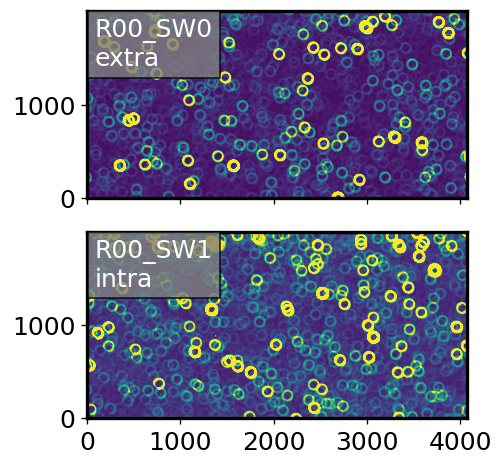

In [4]:
zscale = ZScaleInterval()

if sensor[1] == sensor[2]:
    ncols=1; nrows=2
else:
    ncols=2; nrows=1

fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4, 4), sharex=True, sharey=True, dpi=120)

# intra is more vignetted
if sensor[1] == "4":
    ax = ax[::-1]

# plot the extrafocal chip
i=0
for exposure, label in zip([extraImage, intraImage], ['extra','intra']):
    data = exposure.image.array
    vmin, vmax = zscale.get_limits(data)
    ax[i].imshow(data, vmin=vmin,vmax=vmax,origin="lower")
    ax[i].text(0.02, 0.96, f"{ exposure.getInfo().getDetector().getName()}\n{label}", 
    transform=ax[i].transAxes, ha="left", va="top", c="w",fontsize=15,
             bbox=dict(facecolor='grey', alpha=0.8, edgecolor='black'))
    i=1


plt.tight_layout()
plt.show()

Plot the donut stamps:

In [12]:
extraFocalStamps, extraFocalCatalog = func.get_butler_stamps(repo_dir,instrument=instrument, 
                                      iterN=0, detector=f"{sensor}_SW0",
                                      dataset_type = 'donutStampsExtra', 
                                      collection=collection)

intraFocalStamps, intraFocalCatalog = func.get_butler_stamps(repo_dir,instrument=instrument, 
                                      iterN=0, detector=f"{sensor}_SW1",
                                      dataset_type = 'donutStampsIntra', 
                                      collection=collection)

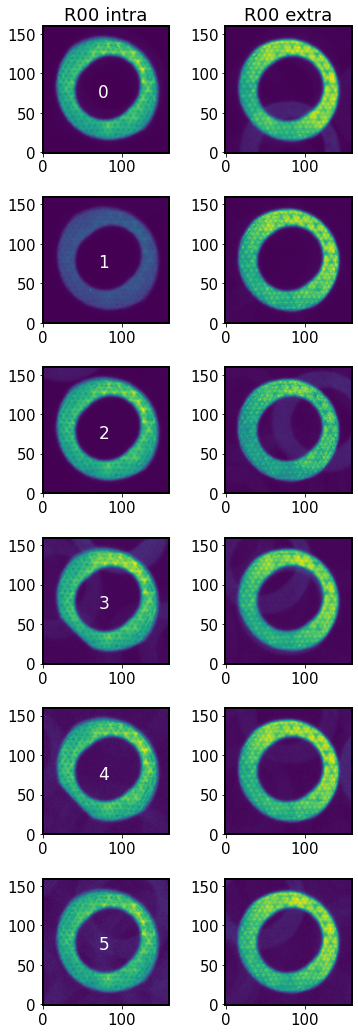

In [13]:
%matplotlib inline

nIntra = len(intraFocalStamps)
nExtra = len(extraFocalStamps)

nDonuts = min(nIntra, nExtra)
ncols = 2
nrows = nDonuts

fig, ax = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows))

for i in range(nDonuts):
    ax[i,0].imshow(intraFocalStamps[i].stamp_im.image.array, origin='lower')
    ax[i,1].imshow(extraFocalStamps[i].stamp_im.image.array, origin='lower')
    ax[i,0].text(70,70, f'{i}', fontsize=17, c='white')
    
fig.subplots_adjust(hspace=0.35)  
ax[0,0].set_title(f'{sensor} intra')
ax[0,1].set_title(f'{sensor} extra')
plt.savefig(f'{sensor}_donuts.png', bbox_inches='tight')

There are 6 intra-focal and 9 extra-focal donuts, but ts_wep at this point simply pairs the two donut lists side-by-side, so that extra donuts are not used. 

### Vary centroid offset - square grid 

Here we experiment with the information on the centroid position `fieldXY` stored in the compensable image. This is used to determine where the donut is on the focal plane, which implies the amount of vignetting in the mask, as well as the expected field location. 

Initially we vary the centroid information exploring a rectangular grid of offsets spanning from -100 px to +100 px in both x and y away from the original donut position. The position of only one donut is updated at a time, i.e. either only intra-focal  or the extra-focal (with the other one having the original centroid position). 

In [14]:
import importlib
importlib.reload(func)

<module 'centroid_functions' from '/sdf/home/s/scichris/WORK/AOS/centroid_functions.py'>

In [15]:
# run the fitting 
repo_name = 'masks_DM-33104/wfs/cwfs_ps1_high_density_10_DM-34565/phosimData/'
repo_dir = os.path.join(path_to_project, repo_name)
func.offset_centroid_square_grid(repo_dir, collection='ts_phosim_9006070', 
                            index_increase='both',
                            experiment_index=1
                           )

Fitting R00

 Fitting sensor R00, donutIntra 0 with donutExtra 0 

Baseline fit already exists as DM-33104/exp-1_R00_baseline_ex-0_in-0.npy
Fitting R00 donuts 0 0 shifting intra centroid 
Skipping already calculated grid...
Fitting R00 donuts 0 0 shifting extra centroid 
Skipping already calculated grid...

 Fitting sensor R00, donutIntra 1 with donutExtra 1 

Baseline fit already exists as DM-33104/exp-1_R00_baseline_ex-1_in-1.npy
Fitting R00 donuts 1 1 shifting intra centroid 
Skipping already calculated grid...
Fitting R00 donuts 1 1 shifting extra centroid 
Skipping already calculated grid...

 Fitting sensor R00, donutIntra 2 with donutExtra 2 

Baseline fit already exists as DM-33104/exp-1_R00_baseline_ex-2_in-2.npy
Fitting R00 donuts 2 2 shifting intra centroid 
Skipping already calculated grid...
Fitting R00 donuts 2 2 shifting extra centroid 
Skipping already calculated grid...

 Fitting sensor R00, donutIntra 3 with donutExtra 3 

Baseline fit already exists as DM-33104/exp-1

119 -47.368421052631575 89.47368421052633 8.102444405989022
120 -47.368421052631575 100.0 8.161882596111957
121 -36.84210526315789 -100.0 7.232878662464848
122 -36.84210526315789 -89.47368421052632 0.9148494654932819
123 -36.84210526315789 -78.94736842105263 0.8152196017194083
124 -36.84210526315789 -68.42105263157895 7.273165919317784
125 -36.84210526315789 -57.89473684210526 7.334673851569959
126 -36.84210526315789 -47.368421052631575 7.396698759707126
127 -36.84210526315789 -36.84210526315789 7.4592122441892394
128 -36.84210526315789 -26.315789473684205 7.488327767175187
129 -36.84210526315789 -15.78947368421052 7.589286785834942
130 -36.84210526315789 -5.263157894736835 7.614515217544648
131 -36.84210526315789 5.26315789473685 7.677424221881409
132 -36.84210526315789 15.789473684210535 7.6785526265836594
133 -36.84210526315789 26.315789473684216 7.741647261662886
134 -36.84210526315789 36.84210526315792 7.795589463228278
135 -36.84210526315789 47.3684210526316 7.859531927016054
136

259 26.315789473684216 89.47368421052633 8.177482897723385
260 26.315789473684216 100.0 8.243082378554957
261 36.84210526315792 -100.0 7.358379284033546
262 36.84210526315792 -89.47368421052632 7.420216865077697
263 36.84210526315792 -78.94736842105263 7.442623786921943
264 36.84210526315792 -68.42105263157895 7.505148703647502
265 36.84210526315792 -57.89473684210526 7.491892274705718
266 36.84210526315792 -47.368421052631575 7.541581282622929
267 36.84210526315792 -36.84210526315789 7.604823541631014
268 36.84210526315792 -26.315789473684205 7.668503283434235
269 36.84210526315792 -15.78947368421052 7.768726250033262
270 36.84210526315792 -5.263157894736835 7.832451285632088
271 36.84210526315792 5.26315789473685 7.848530980701381
272 36.84210526315792 15.789473684210535 7.867967649793692
273 36.84210526315792 26.315789473684216 7.932242106390277
274 36.84210526315792 36.84210526315792 7.996885202726876
275 36.84210526315792 47.3684210526316 8.017600170348262
276 36.84210526315792 57

7 -100.0 -36.84210526315789 1.542537380172171
8 -100.0 -26.315789473684205 1.5271650362296703
9 -100.0 -15.78947368421052 1.5130888117785857
10 -100.0 -5.263157894736835 1.674141349763282
11 -100.0 5.26315789473685 1.6601638080909713
12 -100.0 15.789473684210535 1.6474573474957837
13 -100.0 26.315789473684216 1.6360490196383064
14 -100.0 36.84210526315792 1.625946449647394
15 -100.0 47.3684210526316 1.6171363838224722
16 -100.0 57.89473684210526 1.609710038345818
17 -100.0 68.42105263157896 1.6036640515987746
18 -100.0 78.94736842105266 1.6002516198498624
19 -100.0 89.47368421052633 1.596921652241686
20 -100.0 100.0 1.5949407912435414
21 -89.47368421052632 -100.0 1.6519755966785228
22 -89.47368421052632 -89.47368421052632 1.6295807686323749
23 -89.47368421052632 -78.94736842105263 1.608231317062757
24 -89.47368421052632 -68.42105263157895 1.5831656914936083
25 -89.47368421052632 -57.89473684210526 1.5644382098819358
26 -89.47368421052632 -47.368421052631575 1.5468924643860673
27 -89.47

150 -26.315789473684205 -5.263157894736835 1.6145521640915546
151 -26.315789473684205 5.26315789473685 0.1078372956685799
152 -26.315789473684205 15.789473684210535 0.11287057779080827
153 -26.315789473684205 26.315789473684216 0.13418407391638074
154 -26.315789473684205 36.84210526315792 1.5758448885900131
155 -26.315789473684205 47.3684210526316 1.5696269756881795
156 -26.315789473684205 57.89473684210526 1.5648018186019212
157 -26.315789473684205 68.42105263157896 1.5613623749182957
158 -26.315789473684205 78.94736842105266 1.559331558608131
159 -26.315789473684205 89.47368421052633 1.558705423126229
160 -26.315789473684205 100.0 1.5594806581115421
161 -15.78947368421052 -100.0 1.7836445035793849
162 -15.78947368421052 -89.47368421052632 1.7612763038002661
163 -15.78947368421052 -78.94736842105263 1.7398964537266752
164 -15.78947368421052 -68.42105263157895 1.7195719601810182
165 -15.78947368421052 -57.89473684210526 7.733517768963726
166 -15.78947368421052 -47.368421052631575 7.715

290 47.3684210526316 -5.263157894736835 7.747150752763248
291 47.3684210526316 5.26315789473685 7.7302839999437
292 47.3684210526316 15.789473684210535 7.713606588553926
293 47.3684210526316 26.315789473684216 7.697108080706036
294 47.3684210526316 36.84210526315792 7.680865452576434
295 47.3684210526316 47.3684210526316 7.664884563756302
296 47.3684210526316 57.89473684210526 7.649085615740692
297 47.3684210526316 68.42105263157896 7.627607676722099
298 47.3684210526316 78.94736842105266 1.5596807941500426
299 47.3684210526316 89.47368421052633 1.5631974128259862
300 47.3684210526316 100.0 1.5668892244672104
301 57.89473684210526 -100.0 7.919476681359958
302 57.89473684210526 -89.47368421052632 1.7281993926606287
303 57.89473684210526 -78.94736842105263 1.7096428254961082
304 57.89473684210526 -68.42105263157895 7.864471817028701
305 57.89473684210526 -57.89473684210526 7.846394808560919
306 57.89473684210526 -47.368421052631575 7.82854456481669
307 57.89473684210526 -36.8421052631578

37 -89.47368421052633 68.42105263157896 3.9546416979973498
38 -89.47368421052633 78.94736842105266 4.254670725617959
39 -89.47368421052633 89.47368421052633 4.3133376922889575
40 -89.47368421052633 100.0 4.61721740108911
41 -78.94736842105262 -100.0 0.9953044949577676
42 -78.94736842105262 -89.47368421052633 0.783131414705247
43 -78.94736842105262 -78.94736842105262 0.6758971535786114
44 -78.94736842105262 -68.42105263157895 0.9310818302563403
45 -78.94736842105262 -57.89473684210527 0.9709232104243569
46 -78.94736842105262 -47.36842105263157 1.0343072736963397
47 -78.94736842105262 -36.84210526315788 1.2118182948411207
48 -78.94736842105262 -26.315789473684205 1.7053173230048926
49 -78.94736842105262 -15.78947368421052 1.7533763508351157
50 -78.94736842105262 -5.263157894736835 2.03489823880608
51 -78.94736842105262 5.26315789473685 2.0883177448861048
52 -78.94736842105262 15.789473684210535 2.1439561786388257
53 -78.94736842105262 26.31578947368422 2.2022201933192957
54 -78.947368421

177 -15.78947368421052 68.42105263157896 2.0158629173382425
178 -15.78947368421052 78.94736842105266 2.079668573386831
179 -15.78947368421052 89.47368421052633 2.1450300314093433
180 -15.78947368421052 100.0 2.4057786032292405
181 -5.263157894736835 -100.0 2.1081212436670067
182 -5.263157894736835 -89.47368421052633 1.7577674286564209
183 -5.263157894736835 -78.94736842105262 1.364935380908238
184 -5.263157894736835 -68.42105263157895 1.0479369597832466
185 -5.263157894736835 -57.89473684210527 1.0206330059919255
186 -5.263157894736835 -47.36842105263157 0.8332323050173193
187 -5.263157894736835 -36.84210526315788 0.7660703995802461
188 -5.263157894736835 -26.315789473684205 0.7034581951899396
189 -5.263157894736835 -15.78947368421052 0.30561510406885517
190 -5.263157894736835 -5.263157894736835 0.03843977655579707
191 -5.263157894736835 5.26315789473685 0.26059866200846415
192 -5.263157894736835 15.789473684210535 0.5072421891800485
193 -5.263157894736835 26.31578947368422 0.878195550

318 57.89473684210527 78.94736842105266 0.7357480800886796
319 57.89473684210527 89.47368421052633 0.9144016505151795
320 57.89473684210527 100.0 1.4221579181443584
321 68.42105263157896 -100.0 4.015775545871444
322 68.42105263157896 -89.47368421052633 3.5316801658788743
323 68.42105263157896 -78.94736842105262 3.2629250237006264
324 68.42105263157896 -68.42105263157895 2.631695103162325
325 68.42105263157896 -57.89473684210527 2.759242727113413
326 68.42105263157896 -47.36842105263157 2.524276013814866
327 68.42105263157896 -36.84210526315788 2.4164856810318383
328 68.42105263157896 -26.315789473684205 2.2228797413956736
329 68.42105263157896 -15.78947368421052 1.9988283695214062
330 68.42105263157896 -5.263157894736835 1.3634734552714052
331 68.42105263157896 5.26315789473685 1.3053093550405555
332 68.42105263157896 15.789473684210535 1.0149768797394434
333 68.42105263157896 26.31578947368422 1.0077702169052185
334 68.42105263157896 36.84210526315791 0.9062165451637846
335 68.4210526

66 -68.42105263157895 -47.36842105263157 0.3561367475978651
67 -68.42105263157895 -36.84210526315788 0.2955806273930256
68 -68.42105263157895 -26.315789473684205 0.2813646795738356
69 -68.42105263157895 -15.78947368421052 0.27498673355271824
70 -68.42105263157895 -5.263157894736835 0.27649776872666415
71 -68.42105263157895 5.26315789473685 0.28894032440250667
72 -68.42105263157895 15.789473684210535 0.3084384641787165
73 -68.42105263157895 26.31578947368422 0.3338198160313016
74 -68.42105263157895 36.84210526315791 0.36380985728354825
75 -68.42105263157895 47.36842105263159 0.397378388056853
76 -68.42105263157895 57.89473684210527 0.4688309028094377
77 -68.42105263157895 68.42105263157896 0.5086995905698837
78 -68.42105263157895 78.94736842105266 0.5499313428020107
79 -68.42105263157895 89.47368421052633 0.5922300601229936
80 -68.42105263157895 100.0 0.6353405207615298
81 -57.89473684210527 -100.0 0.47226666547132623
82 -57.89473684210527 -89.47368421052633 0.43242260820089623
83 -57.8

204 5.26315789473685 -68.42105263157895 0.3392024824162329
205 5.26315789473685 -57.89473684210527 0.29307719075906147
206 5.26315789473685 -47.36842105263157 0.2477537365331563
207 5.26315789473685 -36.84210526315788 0.20372878013480575
208 5.26315789473685 -26.315789473684205 0.16219000579583934
209 5.26315789473685 -15.78947368421052 0.07954512241548
210 5.26315789473685 -5.263157894736835 0.036558509579108105
211 5.26315789473685 5.26315789473685 0.031631372368501935
212 5.26315789473685 15.789473684210535 0.07295412656650328
213 5.26315789473685 26.31578947368422 0.11959392489730021
214 5.26315789473685 36.84210526315791 0.1671773723855445
215 5.26315789473685 47.36842105263159 0.2298852443664186
216 5.26315789473685 57.89473684210527 0.2777920124828676
217 5.26315789473685 68.42105263157896 0.34595325256971693
218 5.26315789473685 78.94736842105266 0.39342583582237534
219 5.26315789473685 89.47368421052633 0.4410599270583074
220 5.26315789473685 100.0 0.48876996780595905
221 15.7

344 78.94736842105266 -68.42105263157895 0.4814533160205076
345 78.94736842105266 -57.89473684210527 0.44528849959514916
346 78.94736842105266 -47.36842105263157 0.4117913049267956
347 78.94736842105266 -36.84210526315788 0.3816171869639379
348 78.94736842105266 -26.315789473684205 0.3555562317011212
349 78.94736842105266 -15.78947368421052 0.3328721800801291
350 78.94736842105266 -5.263157894736835 0.31658650573767794
351 78.94736842105266 5.26315789473685 0.3071772119645414
352 78.94736842105266 15.789473684210535 0.30523864534777173
353 78.94736842105266 26.31578947368422 0.3108383838038928
354 78.94736842105266 36.84210526315791 0.32367059213520627
355 78.94736842105266 47.36842105263159 0.3216860907154758
356 78.94736842105266 57.89473684210527 0.34488980489329635
357 78.94736842105266 68.42105263157896 0.37322013579793606
358 78.94736842105266 78.94736842105266 0.40540604667994856
359 78.94736842105266 89.47368421052633 0.5098671152120157
360 78.94736842105266 100.0 0.55764192834

89 -57.89473684210527 -15.78947368421052 0.8206941984978314
90 -57.89473684210527 -5.263157894736835 1.1340014139380288
91 -57.89473684210527 5.26315789473685 1.1899432813648694
92 -57.89473684210527 15.789473684210535 1.2245450673738199
93 -57.89473684210527 26.31578947368422 1.2864267341619795
94 -57.89473684210527 36.84210526315791 1.4471453276624557
95 -57.89473684210527 47.36842105263159 1.51406924145587
96 -57.89473684210527 57.89473684210527 1.7842522258887543
97 -57.89473684210527 68.42105263157896 1.8525774596586375
98 -57.89473684210527 78.94736842105266 2.295878512664016
99 -57.89473684210527 89.47368421052633 2.3746191498761915
100 -57.89473684210527 100.0 2.6658475788345983
101 -47.36842105263157 -100.0 1.383660404478058
102 -47.36842105263157 -89.47368421052633 1.0244708097041928
103 -47.36842105263157 -78.94736842105262 0.9435809806850054
104 -47.36842105263157 -68.42105263157895 0.694356839282688
105 -47.36842105263157 -57.89473684210527 0.49643318535289616
106 -47.3684

228 15.789473684210535 -26.315789473684205 0.9310293063367974
229 15.789473684210535 -15.78947368421052 0.8756827916816627


KeyboardInterrupt: 

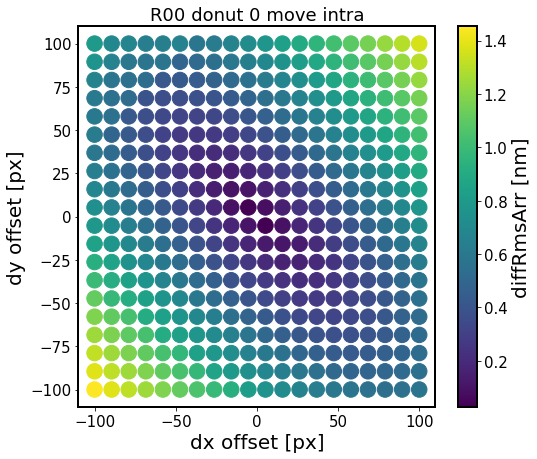

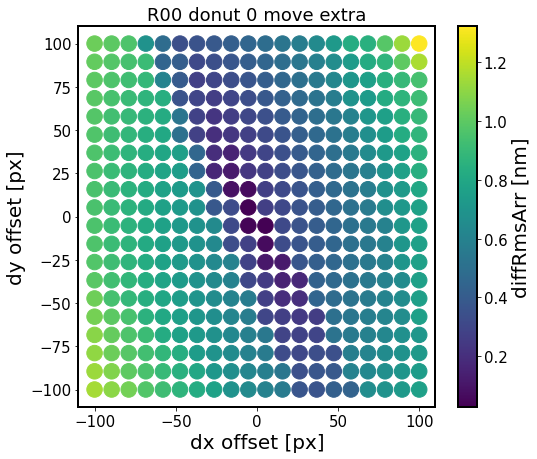

In [24]:
# read the data
sensor = 'R00'
experiment_index = 1 
i_ex = 0
i_in = i_ex
out_dir = 'DM-33104'
for defocal in ['intra','extra']:

    fname = f'exp-{experiment_index}_{sensor}_square_ex-{i_ex}_in-{i_in}_move_{defocal}.npy'
    fpath = os.path.join(out_dir, fname)
    results = np.load(fpath, allow_pickle=True).item()

    # convert to continuous arrays
    diffMaxArr = []
    diffRmsArr = []
    dxPxArr = []
    dyPxArr = []

    # convert the dx, dy in degrees to pixels 
    for j in results.keys():
        dxPxArr.append(results[j]['dxPx'])
        dyPxArr.append(results[j]['dyPx'])
        diffMaxArr.append(results[j]['diffMax'])
        diffRmsArr.append(results[j]['diffRms'])


    fig,ax = plt.subplots(1,1,figsize=(8,7))
    sc = ax.scatter(np.array(dxPxArr), np.array(dyPxArr), c=diffRmsArr, s=240)
    ax.set_xlabel('dx offset [px]')
    ax.set_ylabel('dy offset [px]')
    ax.set_title(f'{sensor} donut {i_ex} move {defocal}')
    plt.colorbar(sc, label = 'diffRmsArr [nm]')

The metric displayed is the root-mean-squared (RMS) difference between a list of no-offset Zernikes (for `dx=dy=0`), vs those at a `dx`, `dy` offset: 

$$ 
RMS = \sqrt{\frac{\sum_{i=4}^{22} |zk_{dx,dy}-zk_{0} |^{2}}  {N} } 
$$


This shows that there is a structure to  RMS difference between offset centroid and the baseline Zernike fit. The RMS difference has a larger gradient in the direction towards/away from the focal plane, which corresponds to smaller/larger degree of vignetting. There are other effects too which are due to background sources and possible background blends. 

### Vary centroid offset - circle 

Here instead of evaluating the RMS difference on a square grid surrounding the initial position of the donut, we investigate how far away from the donut center can we move the centroid before the RMS difference is larger than 1 nanometer (which is a negligible difference, i.e. a very low threshold). We advance the distance away from the donut until the RMS difference has reached the threshold, then advance the position angle. This way we travel all around the donut. If varying centroid offset in all directions had identical effect on the retrieved Zernikes, then the result would be a circle. 

In [5]:
#importlib.reload(func)
# run the fitting
func.offset_centroid_circle(repo_dir ,
    instrument = 'LSSTCam',
    collection='ts_phosim_9006070',
    index_increase='both', 
    experiment_index = 2)


Fitting R00

 Fitting sensor R00, donutIntra 0 with donutExtra 0 

Saved the baseline fit as exp-2_R00_baseline_ex-0_in-0.npy
Fitting R00 donuts 0 0 shifting intra centroid 
Skipping already calculated grid...
Fitting R00 donuts 0 0 shifting extra centroid 
Skipping already calculated grid...

 Fitting sensor R00, donutIntra 1 with donutExtra 1 

Saved the baseline fit as exp-2_R00_baseline_ex-1_in-1.npy
Fitting R00 donuts 1 1 shifting intra centroid 
Skipping already calculated grid...
Fitting R00 donuts 1 1 shifting extra centroid 
Skipping already calculated grid...

 Fitting sensor R00, donutIntra 2 with donutExtra 2 

Saved the baseline fit as exp-2_R00_baseline_ex-2_in-2.npy
Fitting R00 donuts 2 2 shifting intra centroid 
Skipping already calculated grid...
Fitting R00 donuts 2 2 shifting extra centroid 
Skipping already calculated grid...

 Fitting sensor R00, donutIntra 3 with donutExtra 3 

Saved the baseline fit as exp-2_R00_baseline_ex-3_in-3.npy
Fitting R00 donuts 3 3 shift

34, 0.6000000000000001/6.283185307179586, 60, 0.5868766032688992
35, 0.6000000000000001/6.283185307179586, 70, 0.7460568571259145
36, 0.6000000000000001/6.283185307179586, 80, 9.152959755934003
Threshold reached at radius  80
37, 0.8/6.283185307179586, 10, 0.0
38, 0.8/6.283185307179586, 20, 0.1141705533339412
39, 0.8/6.283185307179586, 30, 0.1941267655365071
40, 0.8/6.283185307179586, 40, 0.423275257916057
41, 0.8/6.283185307179586, 50, 0.5182199281701849
42, 0.8/6.283185307179586, 60, 0.5601057868640061
43, 0.8/6.283185307179586, 70, 0.7814485959737731
44, 0.8/6.283185307179586, 80, 9.126992246026482
Threshold reached at radius  80
45, 1.0/6.283185307179586, 10, 0.0
46, 1.0/6.283185307179586, 20, 0.11415224214246464
47, 1.0/6.283185307179586, 30, 0.19214177324367981
48, 1.0/6.283185307179586, 40, 0.39552902847821864
49, 1.0/6.283185307179586, 50, 0.49611909841567947
50, 1.0/6.283185307179586, 60, 0.5366918557629913
51, 1.0/6.283185307179586, 70, 0.759646136335499
52, 1.0/6.28318530717

177, 2.8000000000000003/6.283185307179586, 80, 0.7633363812538677
178, 2.8000000000000003/6.283185307179586, 90, 0.8334020939212098
179, 2.8000000000000003/6.283185307179586, 100, 1.0230370039249554
Threshold reached at radius  100
180, 3.0/6.283185307179586, 10, 0.0
181, 3.0/6.283185307179586, 20, 0.2335921132943079
182, 3.0/6.283185307179586, 30, 0.2856135687747253
183, 3.0/6.283185307179586, 40, 0.52077666952023
184, 3.0/6.283185307179586, 50, 0.5742561591990492
185, 3.0/6.283185307179586, 60, 0.869588561423656
186, 3.0/6.283185307179586, 70, 0.9103888030888654
187, 3.0/6.283185307179586, 80, 0.9813723654965351
188, 3.0/6.283185307179586, 90, 0.9723941306761138
189, 3.0/6.283185307179586, 100, 1.0076662272997967
Threshold reached at radius  100
190, 3.2/6.283185307179586, 10, 0.0
191, 3.2/6.283185307179586, 20, 0.23512908596865129
192, 3.2/6.283185307179586, 30, 0.25941304937368725
193, 3.2/6.283185307179586, 40, 0.553457783367361
194, 3.2/6.283185307179586, 50, 0.7202423141754386
1

319, 5.2/6.283185307179586, 130, 0.44716598649797484
320, 5.2/6.283185307179586, 140, 0.49249154027972325
321, 5.2/6.283185307179586, 150, 0.6795277184117099
322, 5.2/6.283185307179586, 160, 0.727819659447923
323, 5.2/6.283185307179586, 170, 0.7663111180406774
324, 5.2/6.283185307179586, 180, 0.8147339178801645
325, 5.2/6.283185307179586, 190, 0.8650425576944463
326, 5.2/6.283185307179586, 200, 1.0241089791820377
Threshold reached at radius  200
327, 5.4/6.283185307179586, 10, 0.0
328, 5.4/6.283185307179586, 20, 0.05287933952760525
329, 5.4/6.283185307179586, 30, 0.10575641563250562
330, 5.4/6.283185307179586, 40, 0.1586437591423606
331, 5.4/6.283185307179586, 50, 0.2115422236474404
332, 5.4/6.283185307179586, 60, 0.26444695774823723
333, 5.4/6.283185307179586, 70, 0.25738396768629734
334, 5.4/6.283185307179586, 80, 0.28060129600344
335, 5.4/6.283185307179586, 90, 0.3110741898131697
336, 5.4/6.283185307179586, 100, 0.5785534739162859
337, 5.4/6.283185307179586, 110, 0.6146751777584388


37, 0.2/6.283185307179586, 190, 0.8161024515876139
38, 0.2/6.283185307179586, 200, 0.8609950513484275
39, 0.2/6.283185307179586, 210, 0.9169263841458403
40, 0.2/6.283185307179586, 220, 0.9616269308963722
41, 0.2/6.283185307179586, 230, 1.0063549219975338
Threshold reached at radius  230
42, 0.4/6.283185307179586, 10, 0.0
43, 0.4/6.283185307179586, 20, 0.0459941788218099
44, 0.4/6.283185307179586, 30, 0.09566268088995596
45, 0.4/6.283185307179586, 40, 0.13851347124672495
46, 0.4/6.283185307179586, 50, 0.18304719111016962
47, 0.4/6.283185307179586, 60, 0.2282679110034857
48, 0.4/6.283185307179586, 70, 0.27707318377569295
49, 0.4/6.283185307179586, 80, 0.3232505392985424
50, 0.4/6.283185307179586, 90, 0.369599084374602
51, 0.4/6.283185307179586, 100, 0.4160500839600083
52, 0.4/6.283185307179586, 110, 0.462545560650063
53, 0.4/6.283185307179586, 120, 0.5195161637968428
54, 0.4/6.283185307179586, 130, 0.5658735919692532
55, 0.4/6.283185307179586, 140, 0.6122074482605552
56, 0.4/6.2831853071

178, 1.6/6.283185307179586, 140, 0.9638227141195835
179, 1.6/6.283185307179586, 150, 0.9953677550785799
180, 1.6/6.283185307179586, 160, 1.0278316459681922
Threshold reached at radius  160
181, 1.8/6.283185307179586, 10, 0.0
182, 1.8/6.283185307179586, 20, 0.04073760862519531
183, 1.8/6.283185307179586, 30, 0.08156584693257014
184, 1.8/6.283185307179586, 40, 0.1224668462019129
185, 1.8/6.283185307179586, 50, 0.44505017501817334
186, 1.8/6.283185307179586, 60, 0.4730762801046818
187, 1.8/6.283185307179586, 70, 0.7986806694434004
188, 1.8/6.283185307179586, 80, 0.8241942247652325
189, 1.8/6.283185307179586, 90, 0.8509047915575001
190, 1.8/6.283185307179586, 100, 0.8786918983731328
191, 1.8/6.283185307179586, 110, 0.907483899846218
192, 1.8/6.283185307179586, 120, 0.9372561290030713
193, 1.8/6.283185307179586, 130, 0.967914353705751
194, 1.8/6.283185307179586, 140, 0.9992149763161516
195, 1.8/6.283185307179586, 150, 1.031176076567704
Threshold reached at radius  150
196, 2.0/6.28318530717

321, 3.8000000000000003/6.283185307179586, 120, 0.5182920050176263
322, 3.8000000000000003/6.283185307179586, 130, 0.5651326093712463
323, 3.8000000000000003/6.283185307179586, 140, 0.6119683856878734
324, 3.8000000000000003/6.283185307179586, 150, 0.6588170413294391
325, 3.8000000000000003/6.283185307179586, 160, 0.7056628852508157
326, 3.8000000000000003/6.283185307179586, 170, 0.7524810134303109
327, 3.8000000000000003/6.283185307179586, 180, 0.7993374219871197
328, 3.8000000000000003/6.283185307179586, 190, 0.846214096019203
329, 3.8000000000000003/6.283185307179586, 200, 0.8930747059883352
330, 3.8000000000000003/6.283185307179586, 210, 0.939870556329537
331, 3.8000000000000003/6.283185307179586, 220, 0.9866425205892977
332, 3.8000000000000003/6.283185307179586, 230, 1.0334354641974997
Threshold reached at radius  230
333, 4.0/6.283185307179586, 10, 0.0
334, 4.0/6.283185307179586, 20, 0.04731053862767065
335, 4.0/6.283185307179586, 30, 0.0946028435545131
336, 4.0/6.283185307179586

463, 5.2/6.283185307179586, 90, 0.32069603900794635
464, 5.2/6.283185307179586, 100, 0.3589056828978483
465, 5.2/6.283185307179586, 110, 0.3971547609299961
466, 5.2/6.283185307179586, 120, 0.4353988582684256
467, 5.2/6.283185307179586, 130, 0.6881729210373047
468, 5.2/6.283185307179586, 140, 1.0127657816460476
Threshold reached at radius  140
469, 5.4/6.283185307179586, 10, 0.0
470, 5.4/6.283185307179586, 20, 0.037913207671295565
471, 5.4/6.283185307179586, 30, 0.07580563932268487
472, 5.4/6.283185307179586, 40, 0.12758415125714936
473, 5.4/6.283185307179586, 50, 0.16378926807255906
474, 5.4/6.283185307179586, 60, 0.2005800530507189
475, 5.4/6.283185307179586, 70, 0.23770501567321836
476, 5.4/6.283185307179586, 80, 0.27503620475760776
477, 5.4/6.283185307179586, 90, 0.3124539189404666
478, 5.4/6.283185307179586, 100, 0.34984990641083624
479, 5.4/6.283185307179586, 110, 0.38731070470779017
480, 5.4/6.283185307179586, 120, 0.4248253690110339
481, 5.4/6.283185307179586, 130, 0.70066534882

50, 5.0/6.283185307179586, 10, 0.0
51, 5.0/6.283185307179586, 20, 4.4454806799525866
Threshold reached at radius  20
52, 5.2/6.283185307179586, 10, 0.0
53, 5.2/6.283185307179586, 20, 1.6484909467224913
Threshold reached at radius  20
54, 5.4/6.283185307179586, 10, 0.0
55, 5.4/6.283185307179586, 20, 1.4039873186882577
Threshold reached at radius  20
56, 5.6000000000000005/6.283185307179586, 10, 0.0
57, 5.6000000000000005/6.283185307179586, 20, 1.8094505228552773
Threshold reached at radius  20
58, 5.800000000000001/6.283185307179586, 10, 0.0
59, 5.800000000000001/6.283185307179586, 20, 2.5110995252767867
Threshold reached at radius  20
60, 6.0/6.283185307179586, 10, 0.0
61, 6.0/6.283185307179586, 20, 4.287023182672923
Threshold reached at radius  20
62, 6.2/6.283185307179586, 10, 0.0
63, 6.2/6.283185307179586, 20, 3.394222459492232
Threshold reached at radius  20
saved DM-33104/exp-2_R44_circle_ex-4_in-4_move_intra.npy
Fitting R44 donuts 4 4 shifting extra centroid 
0, 0.0/6.28318530717

130, 2.0/6.283185307179586, 110, 0.49489472641152904
131, 2.0/6.283185307179586, 120, 0.5445445362948902
132, 2.0/6.283185307179586, 130, 0.5942375126525641
133, 2.0/6.283185307179586, 140, 0.6438551635796234
134, 2.0/6.283185307179586, 150, 0.6933522867597119
135, 2.0/6.283185307179586, 160, 0.742720385117585
136, 2.0/6.283185307179586, 170, 0.7920237364884708
137, 2.0/6.283185307179586, 180, 0.8412201161113185
138, 2.0/6.283185307179586, 190, 0.8904231754263876
139, 2.0/6.283185307179586, 200, 0.9396692461213277
140, 2.0/6.283185307179586, 210, 0.988830449087326
141, 2.0/6.283185307179586, 220, 1.037919717361464
Threshold reached at radius  220
142, 2.2/6.283185307179586, 10, 0.0
143, 2.2/6.283185307179586, 20, 0.03542099482653963
144, 2.2/6.283185307179586, 30, 0.07084441443841624
145, 2.2/6.283185307179586, 40, 0.10626817065573309
146, 2.2/6.283185307179586, 50, 0.14174333281367762
147, 2.2/6.283185307179586, 60, 0.17729507979974796
148, 2.2/6.283185307179586, 70, 0.212859282860800

272, 3.2/6.283185307179586, 90, 0.7136107250992948
273, 3.2/6.283185307179586, 100, 0.8025555817430134
274, 3.2/6.283185307179586, 110, 0.8914468845171338
275, 3.2/6.283185307179586, 120, 0.9804085582116933
276, 3.2/6.283185307179586, 130, 1.069494676031403
Threshold reached at radius  130
277, 3.4000000000000004/6.283185307179586, 10, 0.0
278, 3.4000000000000004/6.283185307179586, 20, 0.1017170972919096
279, 3.4000000000000004/6.283185307179586, 30, 0.20317698445773652
280, 3.4000000000000004/6.283185307179586, 40, 0.3045714600382887
281, 3.4000000000000004/6.283185307179586, 50, 0.4059223934923357
282, 3.4000000000000004/6.283185307179586, 60, 0.5073467215774238
283, 3.4000000000000004/6.283185307179586, 70, 0.6086698804252907
284, 3.4000000000000004/6.283185307179586, 80, 0.7099512197666759
285, 3.4000000000000004/6.283185307179586, 90, 0.8110986696488631
286, 3.4000000000000004/6.283185307179586, 100, 0.9121186320457757
287, 3.4000000000000004/6.283185307179586, 110, 1.013216552495

414, 5.4/6.283185307179586, 70, 0.19688935611792918
415, 5.4/6.283185307179586, 80, 0.22958321652195435
416, 5.4/6.283185307179586, 90, 0.2622625948122413
417, 5.4/6.283185307179586, 100, 0.2949042250039764
418, 5.4/6.283185307179586, 110, 0.32754791191651195
419, 5.4/6.283185307179586, 120, 0.3601747130290344
420, 5.4/6.283185307179586, 130, 0.3927607095365943
421, 5.4/6.283185307179586, 140, 0.4253473041454185
422, 5.4/6.283185307179586, 150, 0.45794195292580153
423, 5.4/6.283185307179586, 160, 0.4904994594197771
424, 5.4/6.283185307179586, 170, 0.5229463173082
425, 5.4/6.283185307179586, 180, 0.5553456473752936
426, 5.4/6.283185307179586, 190, 0.5877203580186765
427, 5.4/6.283185307179586, 200, 0.6200948545581845
428, 5.4/6.283185307179586, 210, 0.6524474758679817
429, 5.4/6.283185307179586, 220, 0.6848060362184342
430, 5.4/6.283185307179586, 230, 0.7171601613656057
431, 5.4/6.283185307179586, 240, 0.7495360141194358
432, 5.4/6.283185307179586, 250, 0.7818361193102111
433, 5.4/6.283

22, 2.2/6.283185307179586, 10, 0.0
23, 2.2/6.283185307179586, 20, 4.268654348596382
Threshold reached at radius  20
24, 2.4000000000000004/6.283185307179586, 10, 0.0
25, 2.4000000000000004/6.283185307179586, 20, 0.06519347286909487
26, 2.4000000000000004/6.283185307179586, 30, 0.1303596777721027
27, 2.4000000000000004/6.283185307179586, 40, 0.1597583806304303
28, 2.4000000000000004/6.283185307179586, 50, 0.2193475469251773
29, 2.4000000000000004/6.283185307179586, 60, 0.25022444903015956
30, 2.4000000000000004/6.283185307179586, 70, 1.4227538741984878
Threshold reached at radius  70
31, 2.6/6.283185307179586, 10, 0.0
32, 2.6/6.283185307179586, 20, 0.07034685204417428
33, 2.6/6.283185307179586, 30, 0.14062623819827158
34, 2.6/6.283185307179586, 40, 0.21086396077705855
35, 2.6/6.283185307179586, 50, 0.7512044777490574
36, 2.6/6.283185307179586, 60, 2.2667930037513218
Threshold reached at radius  60
37, 2.8000000000000003/6.283185307179586, 10, 0.0
38, 2.8000000000000003/6.283185307179586

76, 1.4000000000000001/6.283185307179586, 50, 0.343463693792332
77, 1.4000000000000001/6.283185307179586, 60, 0.4195554747107343
78, 1.4000000000000001/6.283185307179586, 70, 22.5306754656777
Threshold reached at radius  70
79, 1.6/6.283185307179586, 10, 0.0
80, 1.6/6.283185307179586, 20, 0.07069507792123515
81, 1.6/6.283185307179586, 30, 0.14156651920283528
82, 1.6/6.283185307179586, 40, 0.2125404000508456
83, 1.6/6.283185307179586, 50, 0.3137538183853054
84, 1.6/6.283185307179586, 60, 0.37767176779413153
85, 1.6/6.283185307179586, 70, 0.44380236304320936
86, 1.6/6.283185307179586, 80, 22.55929416848999
Threshold reached at radius  80
87, 1.8/6.283185307179586, 10, 0.0
88, 1.8/6.283185307179586, 20, 0.05729875437766082
89, 1.8/6.283185307179586, 30, 0.11475655426031861
90, 1.8/6.283185307179586, 40, 0.1722357341008298
91, 1.8/6.283185307179586, 50, 0.22980688568198931
92, 1.8/6.283185307179586, 60, 0.3333652275618229
93, 1.8/6.283185307179586, 70, 0.3855973176884513
94, 1.8/6.28318530

220, 3.8000000000000003/6.283185307179586, 40, 0.29760156590145886
221, 3.8000000000000003/6.283185307179586, 50, 0.39712571054386075
222, 3.8000000000000003/6.283185307179586, 60, 0.4966613225414569
223, 3.8000000000000003/6.283185307179586, 70, 0.567236128270608
224, 3.8000000000000003/6.283185307179586, 80, 0.6618862997118832
225, 3.8000000000000003/6.283185307179586, 90, 0.749773449344692
226, 3.8000000000000003/6.283185307179586, 100, 0.8401383385146742
227, 3.8000000000000003/6.283185307179586, 110, 0.9323816453839407
228, 3.8000000000000003/6.283185307179586, 120, 1.025918976956808
Threshold reached at radius  120
229, 4.0/6.283185307179586, 10, 0.0
230, 4.0/6.283185307179586, 20, 0.09928292316600089
231, 4.0/6.283185307179586, 30, 0.19847633288477354
232, 4.0/6.283185307179586, 40, 0.2979083635194754
233, 4.0/6.283185307179586, 50, 0.39752260784008997
234, 4.0/6.283185307179586, 60, 0.49711763877028037
235, 4.0/6.283185307179586, 70, 0.5743016019412944
236, 4.0/6.28318530717958

365, 5.6000000000000005/6.283185307179586, 20, 0.03253003375104119
366, 5.6000000000000005/6.283185307179586, 30, 0.0650021305463239
367, 5.6000000000000005/6.283185307179586, 40, 0.09743133422661165
368, 5.6000000000000005/6.283185307179586, 50, 0.12989561503407115
369, 5.6000000000000005/6.283185307179586, 60, 0.16239655586863036
370, 5.6000000000000005/6.283185307179586, 70, 0.19493115028097685
371, 5.6000000000000005/6.283185307179586, 80, 0.2274656263908913
372, 5.6000000000000005/6.283185307179586, 90, 0.2599135188898116
373, 5.6000000000000005/6.283185307179586, 100, 0.29219827072022114
374, 5.6000000000000005/6.283185307179586, 110, 0.3244159542931
375, 5.6000000000000005/6.283185307179586, 120, 0.3566657868625787
376, 5.6000000000000005/6.283185307179586, 130, 0.3889010417372616
377, 5.6000000000000005/6.283185307179586, 140, 0.4211245908637071
378, 5.6000000000000005/6.283185307179586, 150, 0.45339412235956483
379, 5.6000000000000005/6.283185307179586, 160, 0.4956571224116955

66, 2.0/6.283185307179586, 120, 0.8960518283792525
67, 2.0/6.283185307179586, 130, 0.9128730901969314
68, 2.0/6.283185307179586, 140, 1.498092709311314
Threshold reached at radius  140
69, 2.2/6.283185307179586, 10, 0.0
70, 2.2/6.283185307179586, 20, 0.05446537315568858
71, 2.2/6.283185307179586, 30, 0.10879021817298466
72, 2.2/6.283185307179586, 40, 0.16320767081618817
73, 2.2/6.283185307179586, 50, 0.21768757363384333
74, 2.2/6.283185307179586, 60, 0.3399356273805924
75, 2.2/6.283185307179586, 70, 0.39250639493459705
76, 2.2/6.283185307179586, 80, 0.3676228756820921
77, 2.2/6.283185307179586, 90, 0.37751351702100017
78, 2.2/6.283185307179586, 100, 0.4263066301419929
79, 2.2/6.283185307179586, 110, 0.4572891833044984
80, 2.2/6.283185307179586, 120, 0.4918799574724533
81, 2.2/6.283185307179586, 130, 0.6164120038375073
82, 2.2/6.283185307179586, 140, 0.6414740824813533
83, 2.2/6.283185307179586, 150, 0.6766507335447727
84, 2.2/6.283185307179586, 160, 0.7142577789010943
85, 2.2/6.2831853

10, 0.0/6.283185307179586, 110, 0.6457273276563765
11, 0.0/6.283185307179586, 120, 0.6905395644125344
12, 0.0/6.283185307179586, 130, 0.7361323152326289
13, 0.0/6.283185307179586, 140, 0.7825449245466121
14, 0.0/6.283185307179586, 150, 0.829808868742646
15, 0.0/6.283185307179586, 160, 0.8774893956696603
16, 0.0/6.283185307179586, 170, 0.9255201710010018
17, 0.0/6.283185307179586, 180, 0.9738139351409766
18, 0.0/6.283185307179586, 190, 1.022415459467657
Threshold reached at radius  190
19, 0.2/6.283185307179586, 10, 0.0
20, 0.2/6.283185307179586, 20, 0.34564604287652795
21, 0.2/6.283185307179586, 30, 0.36721446934319407
22, 0.2/6.283185307179586, 40, 0.39411197183280955
23, 0.2/6.283185307179586, 50, 0.42544617204852925
24, 0.2/6.283185307179586, 60, 0.46280356034714487
25, 0.2/6.283185307179586, 70, 0.5041439314416647
26, 0.2/6.283185307179586, 80, 0.5477870621026443
27, 0.2/6.283185307179586, 90, 0.5935536414213577
28, 0.2/6.283185307179586, 100, 0.6405873924825812
29, 0.2/6.283185307

153, 1.6/6.283185307179586, 140, 0.7496590191799738
154, 1.6/6.283185307179586, 150, 0.7897418665082679
155, 1.6/6.283185307179586, 160, 0.8301672311546445
156, 1.6/6.283185307179586, 170, 0.8708703404309651
157, 1.6/6.283185307179586, 180, 0.9117645451416987
158, 1.6/6.283185307179586, 190, 0.9527379861522765
159, 1.6/6.283185307179586, 200, 0.9938722277099885
160, 1.6/6.283185307179586, 210, 1.035312369277983
Threshold reached at radius  210
161, 1.8/6.283185307179586, 10, 0.0
162, 1.8/6.283185307179586, 20, 0.3460016770930396
163, 1.8/6.283185307179586, 30, 0.07621861318402351
164, 1.8/6.283185307179586, 40, 0.11412653872338203
165, 1.8/6.283185307179586, 50, 0.41153459931300607
166, 1.8/6.283185307179586, 60, 0.4376646743127604
167, 1.8/6.283185307179586, 70, 0.4653835604557105
168, 1.8/6.283185307179586, 80, 0.4944546038320396
169, 1.8/6.283185307179586, 90, 0.52623799591365
170, 1.8/6.283185307179586, 100, 0.5589560222916827
171, 1.8/6.283185307179586, 110, 0.5925035203138335
172

299, 2.8000000000000003/6.283185307179586, 120, 0.5463175641717114
300, 2.8000000000000003/6.283185307179586, 130, 0.5800240623751497
301, 2.8000000000000003/6.283185307179586, 140, 0.6146131510874008
302, 2.8000000000000003/6.283185307179586, 150, 0.6500760195853655
303, 2.8000000000000003/6.283185307179586, 160, 0.6864104745944155
304, 2.8000000000000003/6.283185307179586, 170, 0.7233144928521889
305, 2.8000000000000003/6.283185307179586, 180, 0.7607139342716058
306, 2.8000000000000003/6.283185307179586, 190, 0.7987457665179126
307, 2.8000000000000003/6.283185307179586, 200, 0.8371934479024887
308, 2.8000000000000003/6.283185307179586, 210, 0.8759232836365202
309, 2.8000000000000003/6.283185307179586, 220, 0.9147590524940076
310, 2.8000000000000003/6.283185307179586, 230, 0.9537729896554634
311, 2.8000000000000003/6.283185307179586, 240, 0.9929911495458748
312, 2.8000000000000003/6.283185307179586, 250, 1.032364205020194
Threshold reached at radius  250
313, 3.0/6.283185307179586, 10

439, 4.0/6.283185307179586, 180, 0.9806921997863075
440, 4.0/6.283185307179586, 190, 0.8686318809058904
441, 4.0/6.283185307179586, 200, 0.9168960257493403
442, 4.0/6.283185307179586, 210, 0.9653209179261322
443, 4.0/6.283185307179586, 220, 1.0138646751600129
Threshold reached at radius  220
444, 4.2/6.283185307179586, 10, 0.0
445, 4.2/6.283185307179586, 20, 0.04954011205320057
446, 4.2/6.283185307179586, 30, 0.30715032548557075
447, 4.2/6.283185307179586, 40, 0.30745360241245717
448, 4.2/6.283185307179586, 50, 0.3157781559827389
449, 4.2/6.283185307179586, 60, 0.3314319715077892
450, 4.2/6.283185307179586, 70, 0.35341381940483974
451, 4.2/6.283185307179586, 80, 0.38080594156984016
452, 4.2/6.283185307179586, 90, 0.4124353878021003
453, 4.2/6.283185307179586, 100, 0.4473075500620488
454, 4.2/6.283185307179586, 110, 0.4847256622672913
455, 4.2/6.283185307179586, 120, 0.5241487779706103
456, 4.2/6.283185307179586, 130, 0.5651445221372083
457, 4.2/6.283185307179586, 140, 0.607365854149791

580, 5.2/6.283185307179586, 80, 0.25166258984239953
581, 5.2/6.283185307179586, 90, 0.28775965490913025
582, 5.2/6.283185307179586, 100, 0.32380442800694126
583, 5.2/6.283185307179586, 110, 0.412484009711977
584, 5.2/6.283185307179586, 120, 0.43655655988077247
585, 5.2/6.283185307179586, 130, 0.46237032529790206
586, 5.2/6.283185307179586, 140, 0.4678924209518828
587, 5.2/6.283185307179586, 150, 0.504006223774834
588, 5.2/6.283185307179586, 160, 0.5400021383436255
589, 5.2/6.283185307179586, 170, 0.5760127733860851
590, 5.2/6.283185307179586, 180, 0.6120566295518886
591, 5.2/6.283185307179586, 190, 0.6481124704840466
592, 5.2/6.283185307179586, 200, 0.6841311733805809
593, 5.2/6.283185307179586, 210, 0.7201971355903993
594, 5.2/6.283185307179586, 220, 0.7563073215924919
595, 5.2/6.283185307179586, 230, 0.7923781754214001
596, 5.2/6.283185307179586, 240, 0.8285310369055395
597, 5.2/6.283185307179586, 250, 0.8647866553977006
598, 5.2/6.283185307179586, 260, 0.9009831827124806
599, 5.2/6.

722, 6.2/6.283185307179586, 170, 0.893054174585645
723, 6.2/6.283185307179586, 180, 0.9396707787921164
724, 6.2/6.283185307179586, 190, 0.9865540191735098
725, 6.2/6.283185307179586, 200, 1.0335921418892413
Threshold reached at radius  200
saved DM-33104/exp-2_R44_circle_ex-6_in-6_move_extra.npy


Plot the results

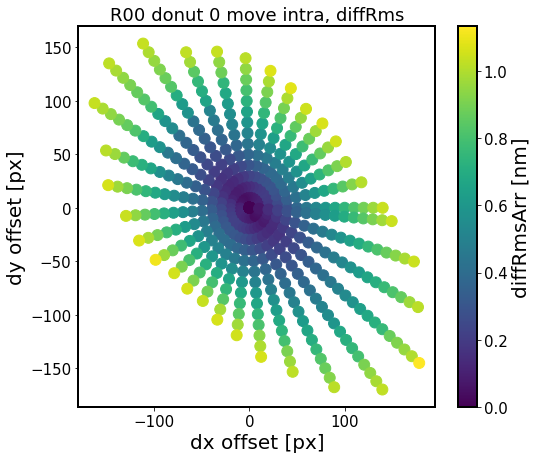

In [6]:
sensor = 'R00'
i = 0
i_ex = i
i_in = i
defocal = 'intra'
out_dir = 'DM-33104'
#fname = f'{sensor}_donut_{i}_{defocal}_offset_results_circle.npy'
#fpath = os.path.join(path_to_project, 'AOS', fname)
experiment_index = 2
fname = f'exp-{experiment_index}_{sensor}_circle_ex-{i_ex}_in-{i_in}_move_{defocal}.npy'
fpath = os.path.join(out_dir, fname)
results = np.load(fpath, allow_pickle=True).item()

diffMaxArr = []
diffRmsArr = []
dxPxArr = []
dyPxArr = []

# convert the dx, dy in degrees to pixels 
for j in results.keys():
    dxPx = results[j]['dxPx']
    dyPx = results[j]['dyPx'] 
    
    dxPxArr.append(dxPx)
    dyPxArr.append(dyPx)

    # calculate max difference and rms difference 
    # just like in test_multImgs.py for ts_wep 
    diffMax = results[j]['diffMax']
    diffRms = results[j]['diffRms']
    diffMaxArr.append(diffMax)
    diffRmsArr.append(diffRms)
    
    
    
fig,ax = plt.subplots(1,1,figsize=(8,7))
sc = ax.scatter(dxPxArr, dyPxArr, c=diffRmsArr, s=120)
ax.set_xlabel('dx offset [px]')
ax.set_ylabel('dy offset [px]')
ax.set_title(f'{sensor} donut {i} move {defocal}, diffRms')
plt.colorbar(sc, label = 'diffRmsArr [nm]')

This shows that we can move over 100 pixels in almost any direction (further away along the tangential direction vs radial). This means that the AOS algorithm is robust to such centroid offsets, i.e. the  computed mask does not change its shape enough to affect the result by more than 1 nm RMS in comparison to the baseline (no offset) calculation. 

Next we overplot the radius at which the 1 nm threshold has been reached on top of the donut stamp for size comparison: 

Text(0.5, 1.0, 'R00 donut 0 move intra, diffRms')

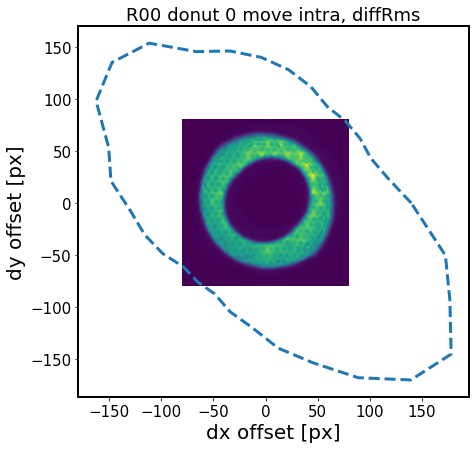

In [7]:
instrument = 'LSSTCam'
collection = 'ts_phosim_9006070'

donutStampsExtra, extraFocalCatalog = func.get_butler_stamps(repo_dir,
                                                        instrument=instrument, 
                                                        iterN=0, 
                                                        detector=f"{sensor}_SW0",
                                                        dataset_type = 'donutStampsExtra', 
                                                        collection=collection)

donutStampsIntra, intraFocalCatalog = func.get_butler_stamps(repo_dir,instrument=instrument, 
                                      iterN=0, detector=f"{sensor}_SW1",
                                      dataset_type = 'donutStampsIntra', 
                                      collection=collection)

imgExtra = donutStampsExtra[i]
imgIntra = donutStampsIntra[i]

imgArray = imgIntra.stamp_im.image.array

jrange = list(results.keys())
dxPxLastArr = []
dyPxLastArr = []
diffRmsLastArr = []
for j in jrange[1:]:
    if results[j]['drPx'] == 0:
        dxPxLastArr.append(results[j-1]['dxPx'])
        dyPxLastArr.append(results[j-1]['dyPx'])
        diffRmsLastArr.append(results[j-1]['diffRms'])
        
fig,ax = plt.subplots(1,1,figsize=(7,7))
dxNew = np.resize(dxPxLastArr,len(dxPxLastArr)+1)
dyNew = np.resize(dyPxLastArr,len(dyPxLastArr)+1)

half = np.shape(imgArray)[0]/2.
x_min = -half
x_max = half
y_min = x_min
y_max = x_max
extent = [x_min , x_max, y_min , y_max]
ax.imshow(imgArray, origin='lower',extent = extent)
ax.plot(dxNew,dyNew,ls='--',lw=3)
N=0

ax.set_xlabel('dx offset [px]')
ax.set_ylabel('dy offset [px]')
ax.set_title(f'{sensor} donut {i} move {defocal}, diffRms')


Having calculated circle of RMS difference for multiple donuts, we plot these in the focal plane coordinates to summarize the results for all sensors. We employ the following steps:


* Read the donut postage stamp (intra, extra)
* Read the results of calculation for a given donut (moving intra, moving extra). 
* Convert the results from a dictionary to array in donut coordinates
* Read out the final radius to obtain an outline 
* Convert to detector coordinates
* Convert to field angle coordinates

* Plot the donut location and the outline of how far can we  move that donut location (fieldXY) passed to the algorithm before the diffRms calculated against the baseline (no offset) is greater than 1 nm (i.e. still barely detectable)



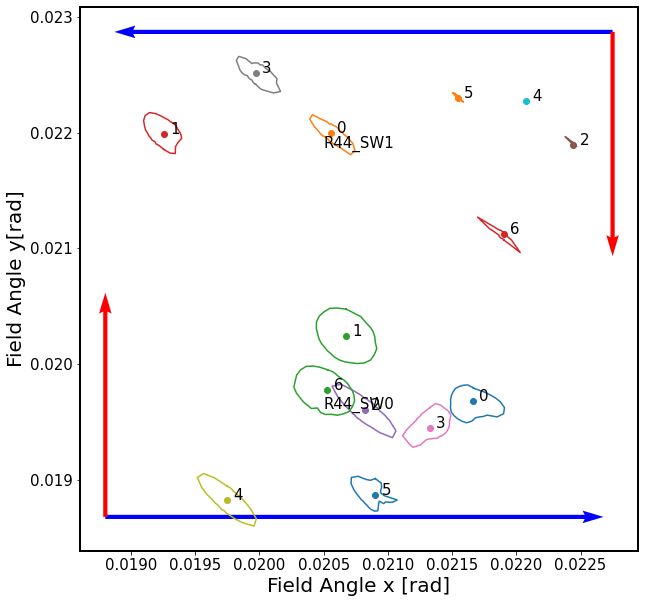

In [94]:
# Load the stamps
instrument = 'LSSTCam'
collection = 'ts_phosim_9006070'
out_dir = 'DM-33104'
repo_name = 'masks_DM-33104/wfs/cwfs_ps1_high_density_10_DM-34565/phosimData/'
repo_dir = os.path.join(path_to_project, repo_name)
def extract_max_radius(results):
    dxPxLastArr = []
    dyPxLastArr = []
    diffRmsLastArr = []
    jrange = list(results.keys())
    for j in jrange[1:]:
        if results[j]['drPx'] == 0:
            dxPxLastArr.append(results[j-1]['dxPx'])
            dyPxLastArr.append(results[j-1]['dyPx'])
            diffRmsLastArr.append(results[j-1]['diffRms'])
    return  dxPxLastArr, dyPxLastArr, diffRmsLastArr

# iterate over all sensors
summary = {}
experiment_index = 2 
for sensor in ['R44',]:    
    donutStampsExtra, extraFocalCatalog = func.get_butler_stamps(repo_dir,instrument=instrument, 
                                          iterN=0, detector=f"{sensor}_SW0",
                                          dataset_type = 'donutStampsExtra', 
                                          collection=collection)

    donutStampsIntra, intraFocalCatalog = func.get_butler_stamps(repo_dir,instrument=instrument, 
                                          iterN=0, detector=f"{sensor}_SW1",
                                          dataset_type = 'donutStampsIntra', 
                                          collection=collection)


    # iterate over all donuts 
    nDonuts = min(len(donutStampsExtra), len(donutStampsIntra))
    for i in range(nDonuts):   
        donutIntra = donutStampsIntra[i]
        donutExtra = donutStampsExtra[i]

        # need to zip because there's different transform for intra 
        # and extra-focal detector 
        for defocal, donut in zip(['extra','intra'], [donutExtra, donutIntra]):
            key = f'{sensor}_{i}_{defocal}'
            summary[key] = {}

            i_in = i
            i_ex = i_in
            fname = f'exp-{experiment_index}_{sensor}_circle_ex-{i_ex}_in-{i_in}_move_{defocal}.npy'
            fpath = os.path.join(out_dir, fname)


            results = np.load(fpath, allow_pickle=True).item()

            # extract the zone reached when diffRms >= 1 nm 
            dxPxLastArr, dyPxLastArr, diffRmsLastArr = extract_max_radius(results)

            # resize to plot an outline by rolling +1 
            dxNew = np.resize(dxPxLastArr,len(dxPxLastArr)+1)
            dyNew = np.resize(dyPxLastArr,len(dyPxLastArr)+1)


            summary[key]['dxOutline'] = dxNew
            summary[key]['dyOutline'] = dyNew


            # transform from donut coords to field angle coords 

            # first, get the camera and detector 

            camera = donut.getCamera()
            detector = camera.get(donut.detector_name)

            # to position in focal plane in radians
            transform = detector.getTransform(PIXELS, FIELD_ANGLE) 
            zero = transform.applyForward(Point2D(0, 0))
            xhat = transform.applyForward(Point2D(4000, 0))
            yhat = transform.applyForward(Point2D(0, 2000))


            centroid = donut.centroid_position
            centroidFieldAngle = transform.applyForward(centroid)

            # transform outline from donut px coords (via centroid) 
            # to detector px coords (via transform) to field coords
            ys = dxNew+centroid.y # treat x as y due to transpose done by ts_wep
            xs = dyNew+centroid.x

            fps = [Point2D(fpx_, fpy_) for fpx_, fpy_ in zip(xs, ys)]

            pixels = transform.applyForward(fps)

            # this is now in field angle coords, i.e. radians 
            fpx = [pixel.x for pixel in pixels]
            fpy = [pixel.y for pixel in pixels]


            # finally get detector center in field angle coord
            center = detector.getCenter(FIELD_ANGLE)
                
            summary[key]['dxOutlineRad'] = fpx
            summary[key]['dyOutlineRad'] = fpy
            summary[key]['centroidDetector'] = centroid
            summary[key]['centroidFieldAngle'] = centroidFieldAngle
            summary[key]['zeroFieldAngle'] = zero
            summary[key]['xHatFieldAngle'] = xhat
            summary[key]['yHatFieldAngle'] = yhat
            summary[key]['detectorCenterFieldAngle'] = center
            summary[key]['detectorName'] = detector.getName()

            
# plot the figure 
fig,ax = plt.subplots(1,1,figsize=(10,10))

coordinates = 'DVCS' # or "CCS"

detectors_plotted = []
for key in summary.keys():
    xhat = summary[key]['xHatFieldAngle']
    yhat = summary[key]['yHatFieldAngle']
    zero = summary[key]['zeroFieldAngle']
    fpx = summary[key]['dxOutlineRad']
    fpy = summary[key]['dyOutlineRad']
    centroidFocal = summary[key]['centroidFieldAngle']
    centroid = summary[key]['centroidDetector'] 
   
    # plot lines 
    if coordinates == 'DVCS':
        ax.plot(fpx,fpy)
        
    elif coordinates == 'CCS':
        ax.plot(fpy,fpx)
    
    if coordinates == 'DVCS':
        ax.scatter(centroidFocal.x, centroidFocal.y)
    elif coordinates == 'CCS':
        ax.scatter(centroidFocal.y, centroidFocal.x)
    
    detector, donut, defocal = key.split('_')

    # plot donut name 
    # DVCS
    if coordinates == 'DVCS':
        ax.text(centroidFocal.x+5*1e-5, centroidFocal.y, donut, fontsize=15)
    # CCS 
    elif coordinates == 'CCS':
        ax.text(centroidFocal.y+5*1e-5, centroidFocal.x, donut, fontsize=15)
    
    # plot the detector outline and names just once 
    det_defocal = ''.join([detector,defocal])
    if det_defocal not in detectors_plotted:
        
        # DVCS : default DM mapping 
        if coordinates == 'DVCS':
            ax.quiver(zero.x, zero.y, xhat.x-zero.x, xhat.y-zero.y, color='blue',lw=2, 
                      scale_units='xy', angles='xy', scale=1)
            ax.quiver(zero.x, zero.y, yhat.x-zero.x, yhat.y-zero.y, color='red', lw=2,
                      scale_units='xy', angles='xy', scale=1)
        elif coordinates == 'CCS':
            # CCS: transpose of DVCS 
            ax.quiver(zero.y, zero.x, xhat.y-zero.y, xhat.x-zero.x, color='blue',lw=2, 
                   scale_units='xy', angles='xy', scale=1)
            ax.quiver(zero.y, zero.x, yhat.y-zero.y, yhat.x-zero.x, color='red', lw=2,
                  scale_units='xy', angles='xy', scale=1)
    
        center = summary[key]['detectorCenterFieldAngle']
        txt = f"{summary[key]['detectorName']}"
        if coordinates == 'DVCS':
            # DVCS 
            text_x, text_y = center.x, center.y
        elif coordinates == 'CCS':
            # CCS
            text_y, text_x = center.x, center.y
        
        ax.text(text_x, text_y, txt, 
                 fontsize=15, horizontalalignment='center', 
                 verticalalignment='center',)# rotation=rotation)

        detectors_plotted.append(det_defocal)
ax.set_xlabel('Field Angle x [rad]')
ax.set_ylabel('Field Angle y[rad]')
plt.savefig(f'{sensor}_diffRms_circle.png', bbox_inches='tight')


In this illustration, we notice that the shorter axis of the  diffRms surface is towards the direction of the center of the focal plane, which corresponds to vignetting being the dominant effect that changes the shape of the mask. For `R00_SW1`,  donuts 2,4,5 have background blended donuts that affects the purity of experiment. For this reason we repeat this calculation using simulated images with well-isolated defocal sources.
    

## Corner sensor simulation - isolated stars, sky background

We use a simulation of isolated stars with two stars on the extra-focal SW0 chip (with less vignetting), and several stars on the  intra-focal (SW1) chip, with increasing degree of vignetting. First, show the postISR images:

In [12]:
# Load the stamps
path_to_project ='/sdf/group/rubin/ncsa-project/project/scichris/aos/'
repo_name  = 'masks_DM-33104/wfs/vignetteSkyQckBg/phosimData/'
repo_dir = os.path.join(path_to_project, repo_name)
print(repo_dir)

instrument = 'LSSTCam'
collection = 'ts_phosim_9006000'
  
# choose R00 or R44
sensor = 'R00'
#print(f'Fitting {sensor}')
donutStampsExtra, extraFocalCatalog = func.get_butler_stamps(repo_dir,instrument=instrument, 
                                      iterN=0, detector=f"{sensor}_SW0",
                                      dataset_type = 'donutStampsExtra', 
                                      collection=collection)

donutStampsIntra, intraFocalCatalog = func.get_butler_stamps(repo_dir,instrument=instrument, 
                                      iterN=0, detector=f"{sensor}_SW1",
                                      dataset_type = 'donutStampsIntra', 
                                      collection=collection)

extraImage = func.get_butler_image(repo_dir,instrument=instrument, 
                              iterN=0, detector=f"{sensor}_SW0",
                              collection=collection)

intraImage = func.get_butler_image(repo_dir,instrument=instrument, 
                              iterN=0, detector=f"{sensor}_SW1",
                              collection=collection)
pixelScaleArcsec = extraImage.getWcs().getPixelScale().asArcseconds()


/sdf/group/rubin/ncsa-project/project/scichris/aos/masks_DM-33104/wfs/vignetteSkyQckBg/phosimData/


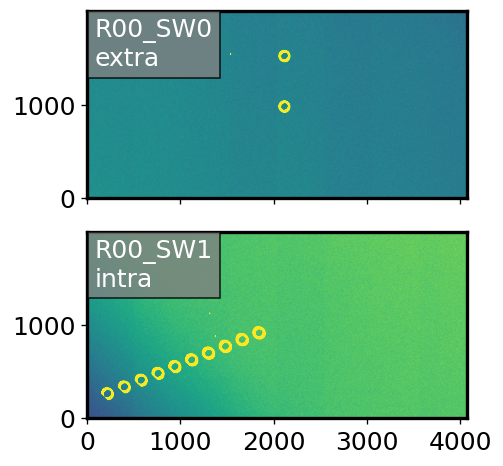

In [13]:
zscale = ZScaleInterval()

if sensor[1] == sensor[2]:
    ncols=1; nrows=2
else:
    ncols=2; nrows=1

fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4, 4), sharex=True, sharey=True, dpi=120)

# intra is more vignetted
if sensor[1] == "4":
    ax = ax[::-1]

# plot the extrafocal chip
i=0
for exposure, label in zip([extraImage, intraImage], ['extra','intra']):
    data = exposure.image.array
    vmin, vmax = zscale.get_limits(data)
    ax[i].imshow(data, vmin=vmin,vmax=vmax,origin="lower")
    ax[i].text(0.02, 0.96, f"{ exposure.getInfo().getDetector().getName()}\n{label}", 
    transform=ax[i].transAxes, ha="left", va="top", c="w",fontsize=15,
             bbox=dict(facecolor='grey', alpha=0.8, edgecolor='black'))
    i=1


plt.tight_layout()
plt.show()

There are multiple intra-focal donut stamps, and only two extra-focal stamps. In normal operation of the `CloseLoopTask`, only two intra-focal donuts would get paired up with the two extra-focal donuts. In this experiment we pair up all intra-focal donuts with the central extra-focal donut. We vary the position first of extra, then intra-focal donut in each pair. This means that if we call  extra-focal donuts e0, e1, and  intra-focal donuts i0, i1, i2 ..., we have pairs  (e0,i0),  (e0,i1),  (e0,i2), ... (e0, iN).  

### Vary centroid offset - square grid 

In [20]:
import importlib
importlib.reload(func)

<module 'centroid_functions' from '/sdf/home/s/scichris/WORK/AOS/centroid_functions.py'>

In [ ]:
# Use the function above with different repo_dir
repo_name = 'masks_DM-33104/wfs/vignetteSkyQckBg/phosimData/'
repo_dir = os.path.join(path_to_project, repo_name)
func.offset_centroid_square_grid(repo_dir, collection='ts_phosim_9006000', 
                            index_increase='intra',
                            experiment_index=3
                           )

Plot of the results:

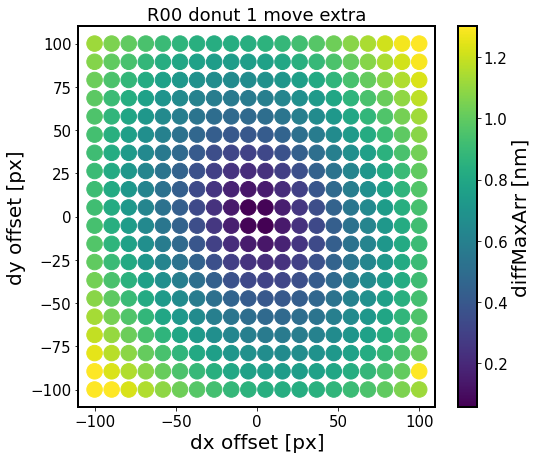

In [68]:
# read the data
sensor = 'R00'
defocal = 'extra'
i_ex = 0
i_in = 0
experiment_index = 3
#fname = f'{sensor}_donut_0_{i}_move_{defocal}_results_square_grid.npy'
#fpath = os.path.join(path_to_project, 'AOS', fname)
out_dir = 'DM-33104'
fname = f'exp-{experiment_index}_{sensor}_square_ex-{i_ex}_in-{i_in}_move_{defocal}.npy'
fpath = os.path.join(out_dir, fname)
results = np.load(fpath, allow_pickle=True).item()

# convert to continuous arrays
diffMaxArr = []
diffRmsArr = []
dxPxArr = []
dyPxArr = []

# convert the dx, dy in degrees to pixels 
for j in results.keys():
    dxPxArr.append(results[j]['dxPx'])
    dyPxArr.append(results[j]['dyPx'])
    diffMaxArr.append(results[j]['diffMax'])
    diffRmsArr.append(results[j]['diffRms'])

    
fig,ax = plt.subplots(1,1,figsize=(8,7))
sc = ax.scatter(np.array(dxPxArr), np.array(dyPxArr), c=diffRmsArr, s=240,
             vmax=1.3)

ax.set_xlabel('dx offset [px]')
ax.set_ylabel('dy offset [px]')
ax.set_title(f'{sensor} donut {i} move {defocal}')
plt.colorbar(sc, label = 'diffMaxArr [nm]')

The results are similar as above. We quantify that below by varying mask offset only in the radial direction. 

### Vary centroid offset - only radial direction

In [ ]:
# run the fitting 
repo_name = 'masks_DM-33104/wfs/vignetteSkyQckBg/phosimData/'
repo_dir = os.path.join(path_to_project, repo_name)
func.offset_centroid_radially(repo_dir, experiment_index=5, drDegMin=-0.1, drDegMax=0.1, nGrid=500,
                        )

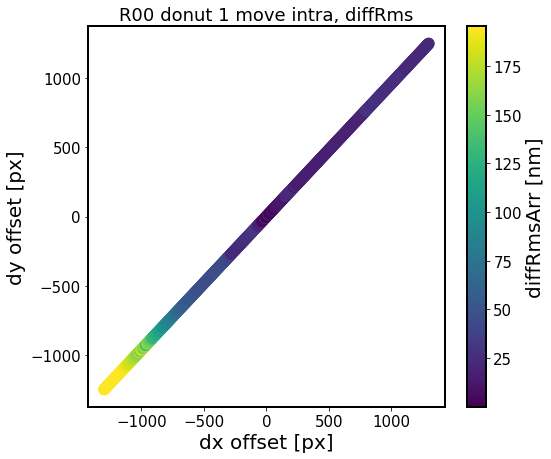

In [18]:
sensor = 'R00'
defocal = 'intra'
i = 1
experiment_index=5
out_dir = 'DM-33104'
fname = f'exp-{experiment_index}_{sensor}_donut_0_{i}_move_{defocal}_results_radialN.npy'
fpath = os.path.join(out_dir, fname)
results = np.load(fpath, allow_pickle=True).item()


diffMaxArr = []
diffRmsArr = []
dxPxArr = []
dyPxArr = []

# convert the dx, dy in degrees to pixels 
for j in results.keys():
    dxPx = results[j]['dxPx']
    dyPx = results[j]['dyPx'] 

    dxPxArr.append(dxPx)
    dyPxArr.append(dyPx)

    # calculate max difference and rms difference 
    # just like in test_multImgs.py for ts_wep 
    diffMax = results[j]['diffMax']
    diffRms = results[j]['diffRms']
    diffMaxArr.append(diffMax)
    diffRmsArr.append(diffRms)

fig,ax = plt.subplots(1,1,figsize=(8,7))
sc = ax.scatter(dxPxArr, dyPxArr, c=diffRmsArr,s=120)
ax.set_xlabel('dx offset [px]')
ax.set_ylabel('dy offset [px]')
ax.set_title(f'{sensor} donut {i} move {defocal}, diffRms')
plt.colorbar(sc, label = 'diffRmsArr [nm]')

Note, that for illustration this assumed unrealistically large offsets (+/- 4000 pixels), which is more than the size of the corner sensor. In reality, these offsets would not be more than a few ~tens of pixels at most. 

Below, for each donut we calculate the number of pixels in the mask different from the baseline mask, as well as the number of pixels  multiplied by the image value. This is possible because at each stage we stored the compensable image.

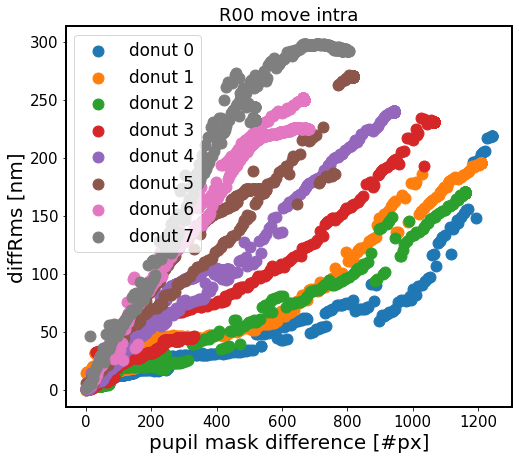

In [20]:
sensor = 'R00'

fig,ax = plt.subplots(1,1,figsize=(8,7))

# read the baseline
for i in range(8):
    experiment_index=5
    out_dir = 'DM-33104'
    fname = f'exp-{experiment_index}_{sensor}_donut_{i}_no_offset_zk_radial.npy'
    fpath = os.path.join(out_dir, fname)
    baseline =  np.load(fpath, allow_pickle=True).item()

    # read the results of shifting i-th intra/extra donut 
    for defocal in ['intra']:


        half = defocal.capitalize()

        mp0 = baseline[f'img{half}'].getNonPaddedMask()
        mc0 =  baseline[f'img{half}'].getPaddedMask()
        img0 = baseline[f'img{half}'].getImg()


        fname = f'exp-{experiment_index}_{sensor}_donut_0_{i}_move_{defocal}_results_radialN.npy'
        fpath = os.path.join(out_dir, fname)
        results = np.load(fpath, allow_pickle=True).item()

        diffMaxArr = []
        diffRmsArr = []
        mcDiffArr = []
        mpDiffArr = []
        for j in results.keys():

            diffMax = results[j]['diffMax']
            diffRms = results[j]['diffRms']
            diffMaxArr.append(diffMax)
            diffRmsArr.append(diffRms)

            mp =  results[j][f'img{half}0mp']
            mc =  results[j][f'img{half}0mc']
            img = results[j][f'img{half}0img']

            # calculate mask difference 
            mcDiffArr.append(np.sum(mc-mc0))
            mpDiffArr.append(np.sum(mp-mp0))
        #print(j)
        sc = ax.scatter(np.abs(mpDiffArr), diffRmsArr , s=120, label=f'donut {i}')

ax.set_xlabel('pupil mask difference [#px]')
ax.set_ylabel('diffRms [nm]')
ax.set_title(f'{sensor} move {defocal}')
ax.legend(fontsize=17)


In the above we shift the intra-focal donut centroid, keeping the extra-focal donut centroid unchanged. Each color represents a different donut. Donuts with increasing id are progressively further away from the center of the focal plane, which means that they react more strongly to smaller change in mask pixels.



Below we calculate the results radially on a much finer grid, and plot the summary results of diffRms vs pupil mask difference [px] for all donuts

In [ ]:
func.offset_centroid_radially(repo_dir,
                         experiment_index=6,
                         drDegMin=None,
                         drDegMax=None,
                         drPxMin=-50,
                         drPxMax=50,
                         nGrid=100)

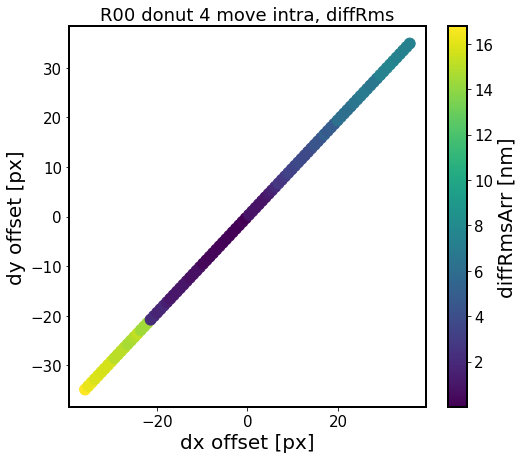

In [21]:
sensor = 'R00'
defocal = 'intra'
i = 4 
fname = f'exp-6_{sensor}_donut_0_{i}_move_{defocal}_results_radialN.npy'
fpath = os.path.join('DM-33104',fname)
results = np.load(fpath, allow_pickle=True).item()


diffMaxArr = []
diffRmsArr = []
dxPxArr = []
dyPxArr = []

# convert the dx, dy in degrees to pixels 
for j in results.keys():
    dxPx = results[j]['dxPx']
    dyPx = results[j]['dyPx'] 

    dxPxArr.append(dxPx)
    dyPxArr.append(dyPx)

    # calculate max difference and rms difference 
    # just like in test_multImgs.py for ts_wep 
    diffMax = results[j]['diffMax']
    diffRms = results[j]['diffRms']
    diffMaxArr.append(diffMax)
    diffRmsArr.append(diffRms)



# plot 
fig,ax = plt.subplots(1,1,figsize=(8,7))
sc = ax.scatter(dxPxArr, dyPxArr, c=diffRmsArr,s=120)
ax.set_xlabel('dx offset [px]')
ax.set_ylabel('dy offset [px]')
ax.set_title(f'{sensor} donut {i} move {defocal}, diffRms')
plt.colorbar(sc, label = 'diffRmsArr [nm]')

Text(0.5, 1.0, 'R00 donut 4 move intra')

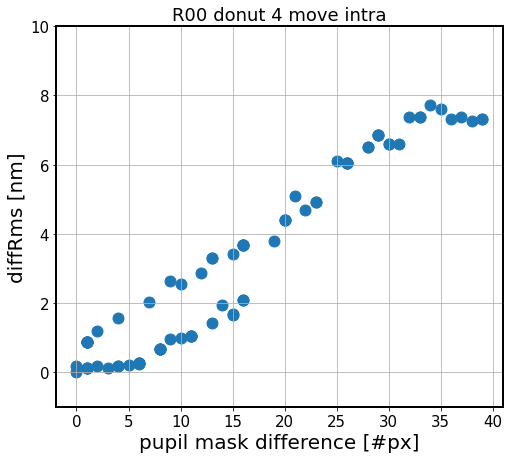

In [22]:
sensor = 'R00'

# read the baseline
fname_base = f'exp-6_{sensor}_donut_{i}_no_offset_zk_radial.npy'
fpath_base = os.path.join('DM-33104',fname_base)
baseline =  np.load(fpath_base, allow_pickle=True).item()
half = defocal.capitalize()

mp0 = baseline[f'img{half}'].getNonPaddedMask()
mc0 =  baseline[f'img{half}'].getPaddedMask()
img0 = baseline[f'img{half}'].getImg()

# read the results of shifting i-th intra/extra donut 
diffMaxArr = []
diffRmsArr = []
mcDiffArr = []
mpDiffArr = []

i=4
defocal='intra'
fname = f'exp-6_{sensor}_donut_0_{i}_move_{defocal}_results_radialN.npy'
fpath = os.path.join('DM-33104',fname)
results = np.load(fpath, allow_pickle=True).item()

for j in results.keys():

    diffMax = results[j]['diffMax']
    diffRms = results[j]['diffRms']
    diffMaxArr.append(diffMax)
    diffRmsArr.append(diffRms)

    mp =  results[j][f'img{half}0mp']
    mc =  results[j][f'img{half}0mc']
    img = results[j][f'img{half}0img']

    # calculate mask difference 
    mcDiffArr.append(np.sum(mc-mc0))
    mpDiffArr.append(np.sum(mp-mp0))

# plot 
fig,ax = plt.subplots(1,1,figsize=(8,7))
sc = ax.scatter(np.abs(mpDiffArr), diffRmsArr , s=120)
ax.set_ylim(-1,10)
ax.grid()
ax.set_xlabel('pupil mask difference [#px]')
ax.set_ylabel('diffRms [nm]')
ax.set_title(f'{sensor} donut {i} move {defocal}')

As above, but on a smaller scale. Here instead of shifts up to 1200 px, they are  +/- 50 px.  

### Vary centroid offset - circle 

In [3]:
# run the fitting
path_to_project ='/sdf/group/rubin/ncsa-project/project/scichris/aos/'
repo_name = 'masks_DM-33104/wfs/vignetteSkyQckBg/phosimData/'
repo_dir = os.path.join(path_to_project, repo_name)
func.offset_centroid_circle(repo_dir ,
    instrument = 'LSSTCam',
    collection='ts_phosim_9006000',
    index_increase='intra', 
    experiment_index = 4)

Fitting R00

 Fitting sensor R00, donutIntra 0 with donutExtra 0 

Saved the baseline fit as exp-4_R00_baseline_ex-0_in-0.npy
Fitting R00 donuts 0 0 shifting intra centroid 
Skipping already calculated grid...
Fitting R00 donuts 0 0 shifting extra centroid 
Skipping already calculated grid...

 Fitting sensor R00, donutIntra 1 with donutExtra 0 

Saved the baseline fit as exp-4_R00_baseline_ex-0_in-1.npy
Fitting R00 donuts 1 0 shifting intra centroid 
Skipping already calculated grid...
Fitting R00 donuts 1 0 shifting extra centroid 
Skipping already calculated grid...

 Fitting sensor R00, donutIntra 2 with donutExtra 0 

Saved the baseline fit as exp-4_R00_baseline_ex-0_in-2.npy
Fitting R00 donuts 2 0 shifting intra centroid 
Skipping already calculated grid...
Fitting R00 donuts 2 0 shifting extra centroid 
Skipping already calculated grid...

 Fitting sensor R00, donutIntra 3 with donutExtra 0 

Saved the baseline fit as exp-4_R00_baseline_ex-0_in-3.npy
Fitting R00 donuts 3 0 shift

12, 0.2/6.283185307179586, 60, 0.8755046338825271
13, 0.2/6.283185307179586, 70, 1.0508106981717944
Threshold reached at radius  70
14, 0.4/6.283185307179586, 10, 0.0
15, 0.4/6.283185307179586, 20, 0.14999780061123433
16, 0.4/6.283185307179586, 30, 0.29915837398855805
17, 0.4/6.283185307179586, 40, 0.44887795368193634
18, 0.4/6.283185307179586, 50, 0.6004194374329418
19, 0.4/6.283185307179586, 60, 0.7510955607914692
20, 0.4/6.283185307179586, 70, 0.9006774057767526
21, 0.4/6.283185307179586, 80, 1.0509152095273915
Threshold reached at radius  80
22, 0.6000000000000001/6.283185307179586, 10, 0.0
23, 0.6000000000000001/6.283185307179586, 20, 0.1294990658789776
24, 0.6000000000000001/6.283185307179586, 30, 0.2577293094987289
25, 0.6000000000000001/6.283185307179586, 40, 0.3866950651398342
26, 0.6000000000000001/6.283185307179586, 50, 0.5170832593072127
27, 0.6000000000000001/6.283185307179586, 60, 0.6465942824114409
28, 0.6000000000000001/6.283185307179586, 70, 0.7751456617596918
29, 0.60

148, 6.0/6.283185307179586, 30, 0.45600051530898267
149, 6.0/6.283185307179586, 40, 0.6844214893581456
150, 6.0/6.283185307179586, 50, 0.9125144274558554
151, 6.0/6.283185307179586, 60, 1.1401674273350058
Threshold reached at radius  60
152, 6.2/6.283185307179586, 10, 0.0
153, 6.2/6.283185307179586, 20, 0.20904109972750481
154, 6.2/6.283185307179586, 30, 0.4177268766612896
155, 6.2/6.283185307179586, 40, 0.6269161179377288
156, 6.2/6.283185307179586, 50, 0.8361274172914158
157, 6.2/6.283185307179586, 60, 1.0449319717938772
Threshold reached at radius  60
saved DM-33104/exp-4_R40_circle_ex-0_in-6_move_extra.npy

 Fitting sensor R40, donutIntra 7 with donutExtra 0 

Saved the baseline fit as exp-4_R40_baseline_ex-0_in-7.npy
Fitting R40 donuts 7 0 shifting intra centroid 
0, 0.0/6.283185307179586, 10, 0.0
1, 0.0/6.283185307179586, 20, 7.479439469591107
Threshold reached at radius  20
2, 0.2/6.283185307179586, 10, 0.0
3, 0.2/6.283185307179586, 20, 7.480881600632244
Threshold reached at rad

51, 3.0/6.283185307179586, 30, 7.143127278512973
Threshold reached at radius  30
52, 3.2/6.283185307179586, 10, 0.0
53, 3.2/6.283185307179586, 20, 6.958355043834533
Threshold reached at radius  20
54, 3.4000000000000004/6.283185307179586, 10, 0.0
55, 3.4000000000000004/6.283185307179586, 20, 6.933562484637093
Threshold reached at radius  20
56, 3.6/6.283185307179586, 10, 0.0
57, 3.6/6.283185307179586, 20, 6.904468982957475
Threshold reached at radius  20
58, 3.8000000000000003/6.283185307179586, 10, 0.0
59, 3.8000000000000003/6.283185307179586, 20, 6.872269447777043
Threshold reached at radius  20
60, 4.0/6.283185307179586, 10, 0.0
61, 4.0/6.283185307179586, 20, 6.8383153470606715
Threshold reached at radius  20
62, 4.2/6.283185307179586, 10, 0.0
63, 4.2/6.283185307179586, 20, 6.803814155064178
Threshold reached at radius  20
64, 4.4/6.283185307179586, 10, 0.0
65, 4.4/6.283185307179586, 20, 6.770138974689908
Threshold reached at radius  20
66, 4.6000000000000005/6.283185307179586, 10, 

18, 1.0/6.283185307179586, 10, 0.0
19, 1.0/6.283185307179586, 20, 0.20345001503556517
20, 1.0/6.283185307179586, 30, 1.4150151538481481
Threshold reached at radius  30
21, 1.2000000000000002/6.283185307179586, 10, 0.0
22, 1.2000000000000002/6.283185307179586, 20, 0.23747124506429784
23, 1.2000000000000002/6.283185307179586, 30, 1.4712316307440403
Threshold reached at radius  30
24, 1.4000000000000001/6.283185307179586, 10, 0.0
25, 1.4000000000000001/6.283185307179586, 20, 0.2815056249366235
26, 1.4000000000000001/6.283185307179586, 30, 1.540439188025859
Threshold reached at radius  30
27, 1.6/6.283185307179586, 10, 0.0
28, 1.6/6.283185307179586, 20, 0.32609303007141416
29, 1.6/6.283185307179586, 30, 1.6150134262064009
Threshold reached at radius  30
30, 1.8/6.283185307179586, 10, 0.0
31, 1.8/6.283185307179586, 20, 0.36506587796657197
32, 1.8/6.283185307179586, 30, 1.6872138649004027
Threshold reached at radius  30
33, 2.0/6.283185307179586, 10, 0.0
34, 2.0/6.283185307179586, 20, 0.3946

19, 1.8/6.283185307179586, 20, 26.191789180337338
Threshold reached at radius  20
20, 2.0/6.283185307179586, 10, 0.0
21, 2.0/6.283185307179586, 20, 24.161070587089526
Threshold reached at radius  20
22, 2.2/6.283185307179586, 10, 0.0
23, 2.2/6.283185307179586, 20, 13.441120593255983
Threshold reached at radius  20
24, 2.4000000000000004/6.283185307179586, 10, 0.0
25, 2.4000000000000004/6.283185307179586, 20, 13.41763008255965
Threshold reached at radius  20
26, 2.6/6.283185307179586, 10, 0.0
27, 2.6/6.283185307179586, 20, 13.396276550891251
Threshold reached at radius  20
28, 2.8000000000000003/6.283185307179586, 10, 0.0
29, 2.8000000000000003/6.283185307179586, 20, 25.792861376576116
Threshold reached at radius  20
30, 3.0/6.283185307179586, 10, 0.0
31, 3.0/6.283185307179586, 20, 25.762585026912195
Threshold reached at radius  20
32, 3.2/6.283185307179586, 10, 0.0
33, 3.2/6.283185307179586, 20, 21.89860536935451
Threshold reached at radius  20
34, 3.4000000000000004/6.283185307179586,

KeyboardInterrupt: 

Plot the results:

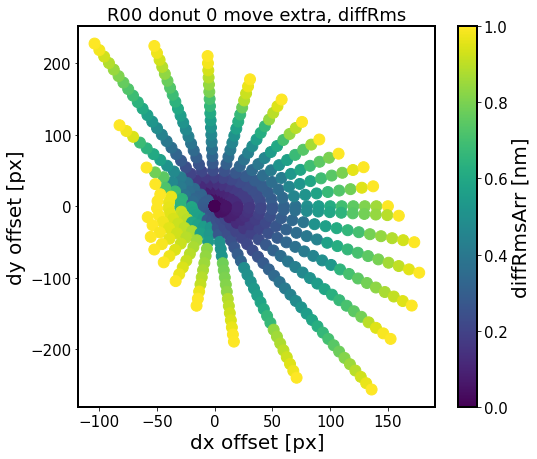

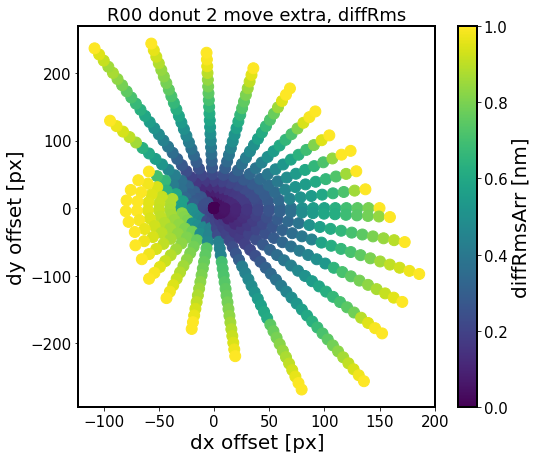

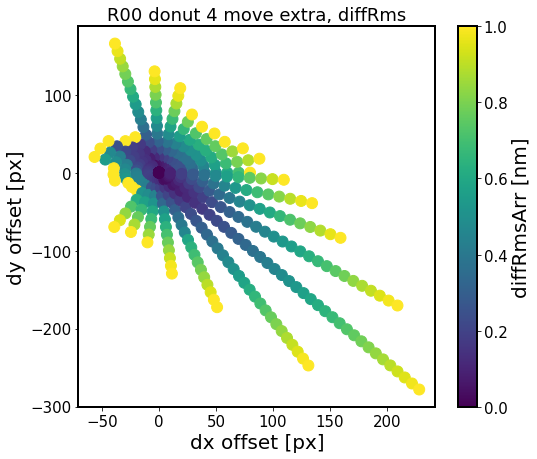

In [99]:
experiment_index = 4
sensor = 'R00'
for i in range(6)[::2]:
    defocal = 'extra'
    #fname = f'VignettingAllSky_{sensor}_donut_{i}_move_{defocal}_results_circle.npy'
    #fpath = os.path.join(path_to_project, 'AOS', fname)
    i_ex = 0
    i_in = i
    
    fname = f'exp-{experiment_index}_{sensor}_circle_ex-{i_ex}_in-{i_in}_move_{defocal}.npy'
    fpath = os.path.join(out_dir, fname)
        
        
    results = np.load(fpath, allow_pickle=True).item()


    diffMaxArr = []
    diffRmsArr = []
    dxPxArr = []
    dyPxArr = []

    # convert the dx, dy in degrees to pixels 
    for j in results.keys():
        dxPx = results[j]['dxPx']
        dyPx = results[j]['dyPx'] 

        dxPxArr.append(dxPx)
        dyPxArr.append(dyPx)

        # calculate max difference and rms difference 
        # just like in test_multImgs.py for ts_wep 
        diffMax = results[j]['diffMax']
        diffRms = results[j]['diffRms']
        diffMaxArr.append(diffMax)
        diffRmsArr.append(diffRms)



    # plot 
    fig,ax = plt.subplots(1,1,figsize=(8,7))
    #N = 100
    sc = ax.scatter(dxPxArr, dyPxArr, c=diffRmsArr, vmax=1.,s=120)
    #ax.scatter(dxPxArr,dyPxArr,c=diffRmsArr, )#bins=20)
    ax.set_xlabel('dx offset [px]')
    ax.set_ylabel('dy offset [px]')
    ax.set_title(f'{sensor} donut {i} move {defocal}, diffRms')
    plt.colorbar(sc, label = 'diffRmsArr [nm]')




Here the region of constant RMS difference is an ellipsoid for donuts 0,2,4 as we would expect for vignetting-dominated effect. The different shapes of that surface for donuts 1, 3 and 6 (not shown) is the result of coarse experiment grid, and would require further investigation on a finer `dx`, `dy` grid. 